In [ ]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
from tqdm import trange
import random
import time
from collections import deque
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
False


In [ ]:
pip install Box2D

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pip install gym[box2d]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
  Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)


In [ ]:
env = gym.make('BipedalWalker-v3')
env_button = {'BipedalWalker-v3': env}

# Set seeds
seed = 88
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3149: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/

In [ ]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(s):
            return env.action_space.sample()

    s = env.reset()
    env.render()

    while True:
        a = policy(s)
        s, _, done, _ = env.step(a)
        env.render()

        if done:
            break

    env.close()

In [ ]:
# Code based on: CS5180 Homework 6: Deep Q-Networks in Pytorch

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = env_button[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in env_button.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


In [ ]:
class Actor(nn.Module):
    def __init__(self, s_size, a_size, a_max):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(s_size, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, a_size)

        self.a_max = a_max

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.a_max * torch.tanh(self.l3(x))

        return x

class Critic(nn.Module):
    def __init__(self, s_size, a_size):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(s_size + a_size, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = self.l3(F.relu(self.l2(F.relu(self.l1(xu)))))

        return x1

In [ ]:
class Buffer(object):
    def __init__(self, s_size, a_size, max_size=int(1e6)):
        self.max_size = max_size

        self.s = torch.empty((max_size, s_size))
        self.a = torch.empty((max_size, a_size))
        self.n_s = torch.empty((max_size, s_size))
        self.r = torch.empty((max_size, 1))
        self.done = torch.empty((max_size, 1))

        self.idx = 0
        self.size = 0

    def add(self, s, a, n_s,  r, done):

        self.s[self.idx] = torch.as_tensor(s).to(device)
        self.a[self.idx] = torch.as_tensor(a).to(device)
        self.n_s[self.idx] = torch.as_tensor(n_s).to(device)
        self.r[self.idx] = torch.as_tensor(r).to(device)
        self.done[self.idx] = torch.as_tensor(1 - done).to(device)

        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        sample_idx = np.random.randint(0, self.size, size=batch_size)

        s = torch.as_tensor(self.s[sample_idx]).to(device)
        a_cpu = torch.as_tensor(self.a[sample_idx])
        n_s = torch.as_tensor(self.n_s[sample_idx]).to(device)
        r = torch.as_tensor(self.r[sample_idx]).to(device)
        done = torch.as_tensor(self.done[sample_idx]).to(device)

        return (s, a_cpu, n_s, r, done)

In [ ]:
class DDPG(object):
    def __init__(self, s_size, a_size, a_max):
        self.actor = Actor(s_size, a_size, a_max).to(device)
        self.actor_target = Actor(s_size, a_size, a_max).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())

        self.critic = Critic(s_size, a_size).to(device)
        self.critic_target = Critic(s_size, a_size).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

        self.a_max = a_max

    def Action(self, s):
        s= torch.FloatTensor(s.reshape(1, -1)).to(device)
        return self.actor(s).cpu().data.numpy().flatten()

    def train(self, buffer, iterations, batch_size=100, discount=0.99, \
              tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

        for it in range(iterations):

            # Sample replay buffer
            s, a_cpu, n_s, r, done = buffer.sample(batch_size)
            a = torch.as_tensor(a_cpu).to(device)

            # Select action according to policy and add clipped noise
            noise = torch.FloatTensor(a_cpu).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            n_a = (self.actor_target(n_s) + noise).clamp(-self.a_max, self.a_max)

            target_Q = self.critic_target(n_s, n_a)
            target_Q = r + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1 = self.critic(s, a)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -self.critic.forward(s, self.actor(s))[0].mean()
            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


In [ ]:
def Train(episodes, save_every=10):

    time_start = time.time()

    T_start = 1e4
    T_total = 0
    steps = 0

    deq_scores = deque(maxlen=100)
    scores = []
    Avg_Scores = []

    a_max = float(env.action_space.high[0])
    a_size = env.action_space.shape[0]
    s_size = env.observation_space.shape[0]

    agent = DDPG(s_size, a_size, a_max)
    buffer = Buffer(s_size, a_size)

    for i in trange(1, episodes + 1):

        timestep = 0
        timestep_max = env._max_episode_steps

        R = 0
        s = env.reset()

        while True:
            if T_total < T_start:
                a = env.action_space.sample()

            else:
                a = agent.Action(np.array(s)) + np.random.normal(0, 0.1, size = a_size)
                a = (a).clip(env.action_space.low, env.action_space.high)

            n_s, r, done, _ = env.step(a)

            timestep += 1
            T_total += 1
            steps += 1

            R += r
            done_ = done

            if timestep == timestep_max:
                done_ = 0

            buffer.add(s, a, n_s, r, done_)
            s = n_s

            if done:
                break

        deq_scores.append(R)
        scores.append(R)

        avg_score = np.mean(deq_scores)
        Avg_Scores.append(avg_score)

        s = (int)(time.time() - time_start)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i, T_total, timestep, \
                        R, avg_score, s//3600, s%3600//60, s%60))

        agent.train(buffer, timestep)

        if len(deq_scores) == 100 and np.mean(deq_scores) >= 300.5:
            print('Environment solved with Average Score: ',  np.mean(deq_scores) )
            break

    return scores, Avg_Scores

In [ ]:
scores, Avg_Scores = Train(episodes = 2000)

100%|██████████| 2000/2000 [1:43:28<00:00,  3.10s/it]


length of scores:  2000 , len of average scores:  2000


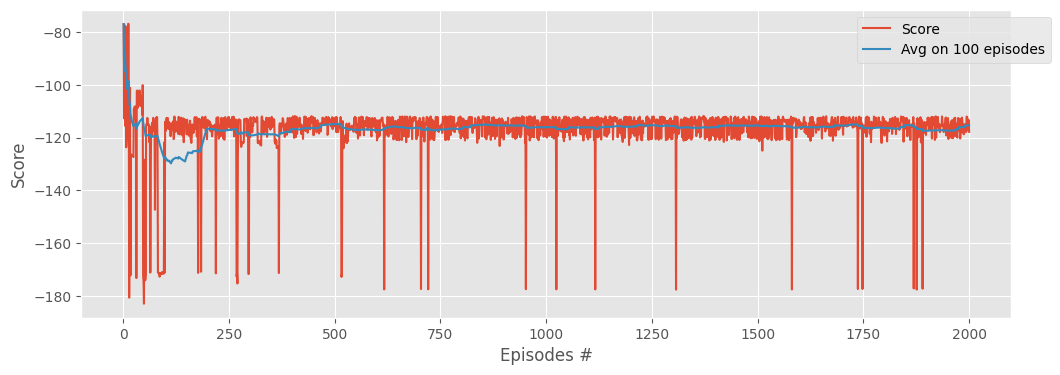

In [ ]:
%matplotlib inline

print('length of scores: ', len(scores), ', len of average scores: ', len(Avg_Scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores, label="Score")
plt.plot(np.arange(1, len(Avg_Scores) + 1), Avg_Scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
env.close

<bound method Wrapper.close of <TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<BipedalWalker<BipedalWalker-v3>>>>>>>